In [4]:
from csv import reader
from os.path import exists

if not exists("../data/train.csv"):
    print("Please generate the training dataset by running ../data/train.py")
    exit()

with open("../data/train.csv", encoding="utf-8", newline="") as file:
    train = [tuple(row) for row in reader(file)]
    print(f"Loaded {len(train)} training pairs")
    romaja, korean = zip(*train)

if not exists("../data/train.csv"):
    print("Please generate the testing dataset by running ../data/test.py")
    exit()

with open("../data/test.csv", encoding="utf-8", newline="") as file:
    test = [tuple(row) for row in reader(file)]
    print(f"Loaded {len(train)} testing pairs")

class Initialize:
    def __init__(self, words):
        self.words = words
        self.charset = list(set("".join(words)))
        self.max = max([len(word) for word in words])
        self.tensors = []

def decompose(word):
    output = ""
    for syllable in word:
        if (u := ord(syllable) - 0xAC00) < 0:
            raise Exception(f'Non-Korean syllable "{syllable}" in word "{word}"')
        l = chr(u // 588 + 0x1100)
        v = chr(u % 588 // 28 + 0x1161)
        t = chr(u % 28 + 0x11A7) if u % 28 else ""
        output += l + v + t
    return output

romaja, korean = Initialize(romaja), Initialize([decompose(word) for word in korean])

charset_max = max(len(romaja.charset), len(korean.charset))

Loaded 100 training pairs
Loaded 100 testing pairs


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_tensors(input: Initialize):
    for word in input.words:
        tensor = torch.zeros(
            max(romaja.max, korean.max),
            1,
            charset_max
        ).to(device)
        for i, char in enumerate(word):
            tensor[i][0][input.charset.index(char)] = 1
        input.tensors.append(tensor)

create_tensors(romaja)
create_tensors(korean)

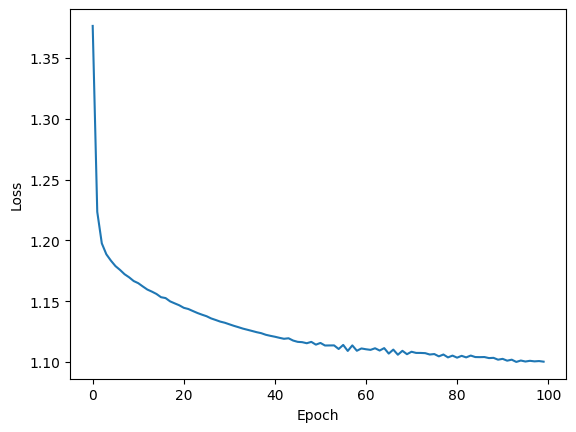

In [6]:
from torch import nn, optim
from matplotlib import pyplot as plt

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        hidden = torch.zeros(1, input.size(0), self.hidden_size).to(device)
        output, hidden = self.rnn(input, hidden)
        return self.linear(output[:, -1, :])
    
model = RNN(charset_max, 128, charset_max).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []
for epoch in range(100):
    total_loss = 0
    for input, target in zip(romaja.tensors, korean.tensors):
        optimizer.zero_grad()
        outputs = model(input)
        loss = criterion(outputs, target.squeeze())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(total_loss / len(romaja.tensors))

torch.save(model.state_dict(), "model.pt")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()